# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
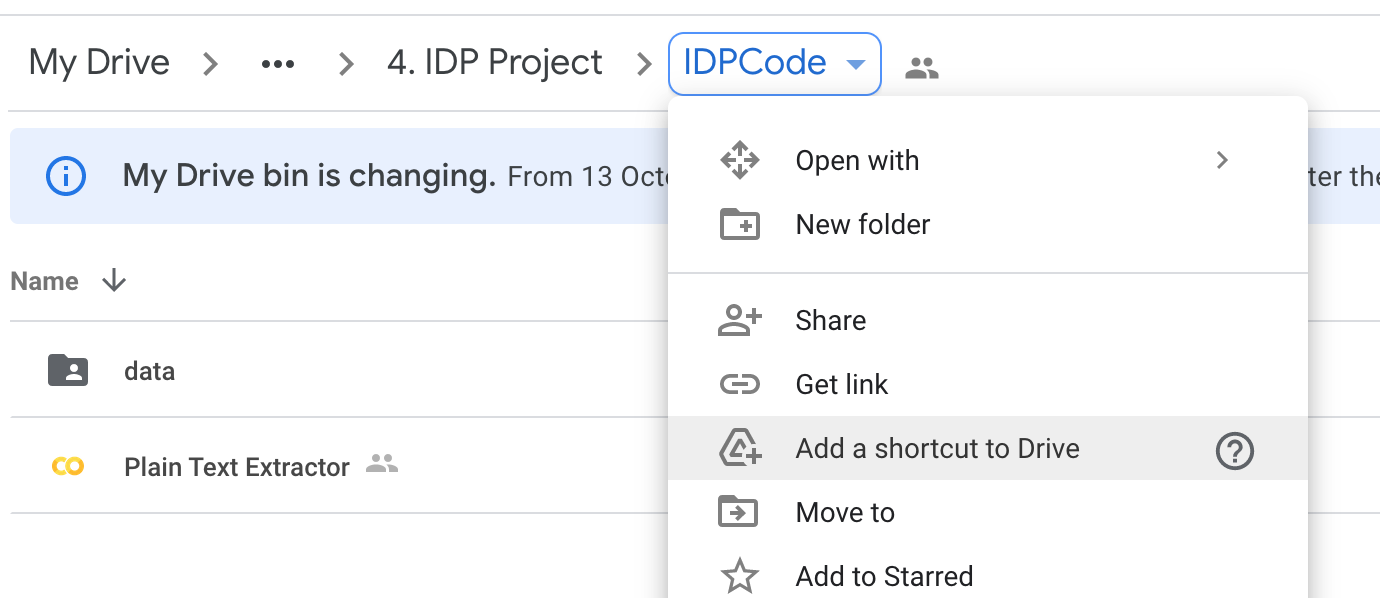
2. Run the command below to connect the GDrive:


In [68]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ModuleNotFoundError: No module named 'google'

time: 201 ms


In [26]:
!pip install xlrd
!pip install spacy
!pip install gensim
!pip install ipython-autotime
!pip install pickle5
!pip install textacy
!pip install spacy-langdetect
!pip install pandarallel

You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgradi

# Start from here if you run in local !!

In [48]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='/Users/farukcankaya/FC/GoogleDrive/AllPapers'


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.33 ms


In [57]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
import textacy
from textacy import preprocessing
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove non-ascii
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '', text)
  # Remove E-Mail addresses
  text = re.sub(r'\b[a-z]+@[a-z]+\b', r'', str(text))
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = re.sub("\n", r' ', text)
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  # https://textacy.readthedocs.io/en/0.10.1/_modules/textacy/preprocessing/normalize.html
  text = textacy.preprocessing.normalize.normalize_whitespace(str(text))
  # replace words with less than 2 characters
  text = re.sub(r'\b[a-z]{1,2}\b', r'', str(text))
    
  return text

def replace_text(text, replacement_texts=REPLACED_WORDS):
  pattern = re.compile("|".join([re.escape(i) for i in replacement_texts]))
  text = pattern.sub(lambda m: '', str(text))
  return text

import spacy
nlp = spacy.load('en')
def lemmatizer(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):        
  sent = []
  doc = nlp(text)
#  for word in doc:
#    sent.append(word.lemma_)
  sent =  [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        texts_out.append(lemmatizer(" ".join(sent), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1
    
def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
  
from IPython.core.display import display, HTML
def print_html(data):
  display(HTML('<div style="width: 90%">'+data+'</div>'))
  
  
def print_lemmatized(text, colorized_ignored=False, ignore_type='allowed'):
  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
  doc_lemma = nlp(text)
  lemms = []
  poses = []
  #colors = ['#f88f88','#DA553F','#045E5B','#731425','#F61E9E','#f44f44','#ff0','#0ff','#f0f']  
  import random
  r = lambda: random.randint(0,255)
  colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

  for token in doc_lemma:
    if token.pos_ not in poses:
      poses.append(token.pos_)

  print(poses)
  for token in doc_lemma:
    if (ignore_type=='allowed' and token.pos_ not in allowed_postags) or (ignore_type=='stop_word' and token.is_stop):
      ignored_color = '#FF8983' if colorized_ignored else colors[poses.index(token.pos_)]
      
      lemms.append('<span style="color: #fff; padding: 0 10px; background-color: '+ignored_color+'"> '+token.lemma_+' </span>')
    else:
      lemms.append(token.lemma_)
      
  print_html('allowed_postags: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[allowed_postags.index(i)]+'"> '+i+' </span>' for i in allowed_postags]))
  print_html('available: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[poses.index(i)]+'"> '+i+' </span>' for i in poses]))
  print_html(' '.join(lemms))
  
import os
def get_file_name(file_path):
  f = os.path.basename(file_path)
  return f.replace('.pdf', '')

def run_in_parallel(dt, function, n_cores=8):
    df_n = np.array_split(df, n_cores)

    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_n))
    pool.close()
    pool.join()
    return df

time: 36.3 s


# Initial Info about the dataset
The dataset in 'All_Papers_In_Plain_Text_TIKA.pkl' contains extracted text page by page per document. Each document has one row and has columns as much as they need in the dataset. Any datapreprocessing step is not applied to data in 'All_Papers_In_Plain_Text_TIKA.pkl'. It is not even normalized. It has many documents that have just one page. Our purpose here was to test the accuracy value against different datapreprocessing steps as simple as we can. Afterwards, we will do further tests by normalizing the data. So to summerize:
- We use all 15750 document that we have as it is
- We used Tika to extract the texts from PDF documents
- We didn't exclude any documents based on their relavences
- We didn't normalized the data, it may contain wrong extracted text

## You can skip '1. Data pre-processing' section and use  the pre-processed data by the code below:

In [50]:
# dt = pd.read_pickle('en_cleaned_mallet_stop_words_lemmatized_all_pages_separetely.pkl') # https://drive.google.com/file/d/1wOnaUYVSu-vI0tQr9xe_gjCLKcapX1bd/view?usp=sharing
dt = pickle.load(open('en_cleaned_accounting_replaced_stop_words_lemmatized_all_pages_separetely.pkl', "rb"))

time: 34.7 s


In [51]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
time: 5.39 ms


# 1. Data pre-processing

In [ ]:
# dt = Dataset Tika
dt = pd.read_pickle('All_Papers_In_Plain_Text_TIKA.pkl') # https://drive.google.com/file/d/1mF88eFEKtni3Sr8jYo2Yo6-rqIunbMgi/view?usp=sharing

time: 7.43 s


## 1.1. Clean text
- Lowercase
- Remove bracket, punctuation and numbers
- Remove links
- Remove newline characters
- Remove text in square brackets
- Remove words containing numbers ???

In [52]:
col_page = [col for col in dt if col.startswith('page') and not col.endswith('_wc')]
col_page_wc = [col for col in dt if col.startswith('page') and col.endswith('_wc')]

time: 5.6 ms


In [ ]:
for page in col_page:
  text_series = dt[page].parallel_apply(clean_text)
  dt['cleaned_' + page] = text_series
  dt['cleaned_' + page + '_wc'] = text_series.parallel_apply(word_count)

time: 8min 18s


## 1.2. Detect document language and remove non-English Sentences

In [80]:
import en_core_web_sm
nlp = en_core_web_sm.load()
#https://pypi.org/project/spacy-langdetect/
from spacy_langdetect import LanguageDetector
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

time: 1.13 s


In [81]:
def remove_non_english_sent(text):
  doc = nlp(text)
  return ' '.join([sent.text for sent in doc.sents if sent._.language["language"] == 'en'])

def document_lang(text):
  doc = nlp(text)
  return doc._.language["language"]

time: 812 µs


In [ ]:
for page in col_page:
  dt['en_cleaned_' + page] = dt['cleaned_' + page].parallel_apply(remove_non_english_sent)

time: 13h 20min 54s


In [ ]:
dt.to_pickle('en_clean_content_separately.pkl')

time: 52.4 s


In [133]:
REPLACED_WORDS_EXCEL = pd.read_excel('data/StopWords/removed_words.xlsx')
REPLACED_WORDS = REPLACED_WORDS_EXCEL[REPLACED_WORDS_EXCEL['Reasonable?']==True]
REPLACED_WORDS.head(10)
print(f'Number of words: {len(REPLACED_WORDS_EXCEL)}')
print(f'Number of approved words: {len(REPLACED_WORDS)}')
REPLACED_WORDS.head(10)
REPLACED_WORDS = REPLACED_WORDS['Removed Words'].values
print(REPLACED_WORDS)

Number of words: 289
Number of approved words: 76
['framework for the analysis' 'testingic auditing' 'review process'
 'journal accounting and public policy' 'the accounting review'
 'accounting forum' 'critical perspectives accointing'
 'accounting and business research'
 'accounting auditing accountability journal' 'doi' 'new york'
 'managementothing' 'winter' 'accounting and finance' 'copyright'
 'account public policy' 'accounting research and policy making'
 'november' 'accounting horizons' 'june' 'ybare' 'aos' 'fdi'
 'int tax public finance' 'european accounting review'
 'management accounting research' 'jel classification' 'the role big'
 'research managerial accounting learning' 'managerial auditing journal'
 'autumn' 'february' 'issnmanagement accounting research' 'peer reviews'
 'disclosuresnge' 'mcb university press' 'may' 'available online'
 'sarbanesoxley act' 'rev account stud' 'december' 'july' 'fall'
 'contemporary accounting research' 'march' 'january'
 'vale louis gol

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.it

In [14]:
# Extracted from PDF metadata:subject. Most of them contains journal names.
REPLACED_WORDS = ['option repricing',
 'tax based accounting system',
 'internal audit',
 'modified audit opinions',
 'confidence',
 'pcaob',
 'delegation',
 'accounting research and policy making',
 'the effects fee pressure',
 'conservatism',
 'cost capital',
 'auditor testing strategies',
 'form',
 'investment banking',
 'fdi',
 'critical perspectives accounting',
 'accounting organizations and society',
 'earnings forecasts',
 'accounting horizons',
 'diluted earnings per share',
 'contemporary accounting research',
 'int tax public finance',
 'cfo turnover',
 'hypothesis testing',
 'managerial auditing journal',
 'securitization income',
 'research managerial accounting learning',
 'fair value',
 'book income adjustment',
 'endogeneity',
 'incentive contracts',
 'advertising',
 'transfer prices',
 'european accounting review',
 'copyright',
 'the british accounting review',
 'instrumental variables',
 'evaluation the effect',
 'auditors risk assessments',
 'debt contracting',
 'corporate annual reports',
 'stock offering',
 'critical perspectives acconting',
 'sfas',
 'derivative financial instruments',
 'low balling',
 'comparative evaluation belief',
 'implied volatility',
 'professional qualifications',
 'loan loss provision',
 'moral hazard',
 'compensation consultants',
 'abstract',
 'loss profit mispricing',
 'methodological biasesax',
 'accruals',
 'chen',
 'international tax and public finance',
 'management accounting research',
 'financial targets',
 'memo structure',
 'accounting recognition',
 'audit fees',
 'analyst research',
 'brokerage research',
 'doi',
 'communication',
 'audit quality',
 'relative performance evaluation',
 'audit risk',
 'auditor evaluation evidence obtained',
 'industry concentration',
 'capital markets research and accounting',
 'private information',
 'terminal values',
 'cooperation',
 'auditor industry specialization',
 'strategic expenditures',
 'framework for the analysis',
 'october',
 'stock options',
 'loss profit predictability',
 'vol',
 'analysts',
 'audits for fraud',
 'experimental economics',
 'organizational structure',
 'governance',
 'persistence',
 'subspaces',
 'partial observability model',
 'market efficiency',
 'accountability',
 'book tax conformity',
 'learning',
 'journal accounting and public policy',
 'springer science business',
 'the role big',
 'peer reviews',
 'february',
 'agency costs',
 'capital investment',
 'internal control',
 'employee stock options',
 'auditor tenure',
 'substantive',
 'market reaction',
 'accounting accruals',
 'investor recognition hypothesis',
 'estimation',
 'pin',
 'cash bonuses',
 'analysts recommendations',
 'information discovery',
 'earnings announcements',
 'reporting discretion',
 'voluntary disclosure',
 'vale louis goldberg',
 'disclosure',
 'peer group',
 'uncertainty',
 'january',
 'future cash flows',
 'executive compensation',
 'the structure profit sharing',
 'thresholds',
 'manipulation',
 'real activities',
 'financial information',
 'information content',
 'industry specialization',
 'internal control assessment',
 'auditors',
 'november',
 'analytical procedures',
 'review process',
 'ceo compensation',
 'voluntary disclosures',
 'managementothing',
 'financial reporting',
 'aggregation',
 'critical perspecives accounting',
 'sarbanesoxley act',
 'credibility',
 'asset securitizations',
 'impairment',
 'information risk',
 'acquisitions',
 'usefulness earnings',
 'japanese managers',
 'implicit deposit insurance and deposit',
 'seasoned equity offerings',
 'autumn',
 'independent',
 'expenditures',
 'management compensation',
 'director elections',
 'taxation',
 'depreciation method choice',
 'cost accounting',
 'available online',
 'behavioral finance',
 'accounting auditing accountability journal',
 'earnings response coefficients',
 'financial reporting quality',
 'double entry',
 'economic conditions',
 'ifrs',
 'improving analytical procedures case',
 'analysis the relative',
 'critical perspectivres accounting',
 'defence the survey',
 'earnings based anomalies',
 'british accounting review',
 'accounting choices',
 'the accounting review',
 'taxes',
 'review accounting studies',
 'rev account stud',
 'december',
 'corporate risk taking',
 'firm performance',
 'momentum',
 'post earnings announcement drift',
 'new york',
 'journal accounting and economics',
 'audit workpapers',
 'account public policy',
 'product market competition',
 'earnings guidance',
 'march',
 'insider trading',
 'corporate advisors',
 'issnmanagement accounting research',
 'tax noncompliance',
 'earnings forecast',
 'may',
 'stock market',
 'aos',
 'the information environment and the',
 'agency model',
 'capital investments',
 'august',
 'testingic auditing',
 'april',
 'internal control over financial reporting',
 'accounting and finance',
 'residual income model',
 'earnings quality',
 'materiality',
 'june',
 'compensation',
 'asymmetric timeliness',
 'jel classification',
 'accounting forum',
 'summer',
 'risk',
 'firm year measure',
 'time budgets',
 'investment policy',
 'security analysts',
 'sarbanes oxley',
 'entrenchment',
 'audit committees',
 'forecast errors',
 'complexity',
 'aaaj',
 'american accounting association',
 'agency theory',
 'september',
 'risk management behavior',
 'earnings surprises',
 'financial graphs',
 'disclosuresnge',
 'board directors',
 'ybare',
 'capital markets',
 'fdicia',
 'accounting conservatism',
 'divestitures',
 'firm size',
 'mcb university press',
 'earnings dilutionr share',
 'earnings management',
 'information asymmetry',
 'july',
 'internal controls',
 'regulation',
 'outsourcing',
 'straight line depreciation',
 'auditor choice',
 'accounting losses profits',
 'decision making',
 'performance measurement',
 'valuation',
 'sox',
 'critical perspectives accointing',
 'auditing market',
 'experimental research method',
 'reputation',
 'accounting and business research',
 'preparers conclusion',
 'legal liability',
 'management forecast accuracy',
 'shielding',
 'earnings',
 'informativeness book tax differences',
 'management forecasts',
 'verification',
 'management guidance',
 'accelerated depreciation',
 'winter',
 'securitizations',
 'competition',
 'critical prespectives accounting',
 'earnings persistence',
 'corporate democracy',
 'timely loss recognition',
 'critical perspective accounting',
 'legislative policy',
 'corporate governance',
 'book tax differences',
 'international journal accounting information systems',
 'fall',
 'board director compensation',
 'privatization',
 'managerial perceptions',
 'litigation',
 'asset measurement']

time: 1.43 ms


In [15]:
dt.index[dt['en_cleaned_accounting_replaced_page_1'].str.match(REPLACED_WORDS[4])]

Int64Index([6900, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910,
            ...
            8021, 8022, 8023, 8024, 8025, 8026, 8027, 8029, 8030, 8032],
           dtype='int64', length=1014)

time: 22.3 ms


In [144]:
dt.iloc[6900]['en_cleaned_page_1']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'the accounting review american accounting association vol   directors   state controlled chinese firms listed  hong kong genuine compensation zhihong chen yuyan guan city university  hong kong bin  nanyang technological university abstract  examine the determinants and consequences   stock option compensation  directors   state controlled chinese firms that are incorporated outside china and listed  hong kong referred   state controlled red chip firms over the period  find that state controlled red chip firms granted directors  significant number  stock options   the demand   foreign investors however state controlled red chip firms forced the directors  forfeit  significant percentage   their vested   the money stock options due   conflict between the high powered stock option compensation and state controlled red chip firms unique managerial labor market  find little evidence that directors stock option compensation changed the behavior   state controlled red chip firms overall our 

time: 6.33 ms


In [143]:
dt.iloc[6900]['en_cleaned_accounting_replaced_page_1']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'directors state controlled chinese firms listed hong kong genuine compensation zhihong yuyan guan city university hong kong bin nanyang technological university examine the determinants and consequences stock option compensation directors state controlled chinese firms that are incorporated outside china and listed hong kong referred state controlled red chip firms over the period find that state controlled red chip firms granted directors significant number stock options the demand foreign investors however state controlled red chip firms forced the directors forfeit significant percentage their vested the money stock options due conflict between the high powered stock option compensation and state controlled red chip firms unique managerial labor market find little evidence that directors stock option compensation changed the behavior state controlled red chip firms overall our results are consistent with themedias allegation that the stock options granted directors many not all sta

time: 817 ms


In [56]:
x='accounting'
#text = re.sub(r'\b'+r''+str(x)+r'\b', '', dt.iloc[6900]['en_cleaned_page_1'])
text = replace_test(dt.iloc[6900]['en_cleaned_page_1'])

'     directors   state controlled chinese firms listed  hong kong genuine compensation zhihong  yuyan guan city university  hong kong bin  nanyang technological university   examine the determinants and consequences   stock option compensation  directors   state controlled chinese firms that are incorporated outside china and listed  hong kong referred   state controlled red chip firms over the period  find that state controlled red chip firms granted directors  significant number  stock options   the demand   foreign investors however state controlled red chip firms forced the directors  forfeit  significant percentage   their vested   the money stock options due   conflict between the high powered stock option compensation and state controlled red chip firms unique managerial labor market  find little evidence that directors stock option compensation changed the behavior   state controlled red chip firms overall our results are consistent with themedias allegation that the stock opt

time: 19.7 ms


In [134]:
for i in REPLACED_WORDS:
  matched_index = dt.index[dt['en_cleaned_accounting_replaced_page_1'].str.match(i)]
  print(str(len(matched_index)) + " -- " + i)
#dt.iloc[matched_index]['en_cleaned_page_1'].values[2]

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0 -- framework for the analysis
0 -- testingic auditing
0 -- review process
160 -- journal accounting and public policy
0 -- the accounting review
0 -- accounting forum
0 -- critical perspectives accointing
0 -- accounting and business research
0 -- accounting auditing accountability journal
0 -- doi
0 -- new york
0 -- managementothing
0 -- winter
0 -- accounting and finance
0 -- copyright
0 -- account public policy
0 -- accounting research and policy making
0 -- november
0 -- accounting horizons
0 -- june
0 -- ybare
0 -- aos
0 -- fdi
0 -- int tax public finance
0 -- european accounting review
0 -- management accounting research
0 -- jel classification
0 -- the role big
0 -- research managerial accounting learning
0 -- managerial auditing journal
0 -- autumn
0 -- february
0 -- issnmanagement accounting research
0 -- peer reviews
0 -- disclosuresnge
0 -- mcb university press
0 -- may
0 -- available online
0 -- sarbanesoxley act
0 -- rev account stud
0 -- december
0 -- july
0 -- fall
0 -

In [139]:
for page in col_page:
  dt['en_cleaned_accounting_replaced_' + page] = dt['en_cleaned_accounting_replaced_' + page].parallel_apply(replace_text)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 8min 32s


In [142]:
for i in REPLACED_WORDS:
  matched_index = dt.index[dt['en_cleaned_accounting_replaced_page_1'].str.match(i)]
  print(str(len(matched_index)) + " -- " + i)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0 -- framework for the analysis
0 -- testingic auditing
0 -- review process
0 -- journal accounting and public policy
0 -- the accounting review
0 -- accounting forum
0 -- critical perspectives accointing
0 -- accounting and business research
0 -- accounting auditing accountability journal
0 -- doi
0 -- new york
0 -- managementothing
0 -- winter
0 -- accounting and finance
0 -- copyright
0 -- account public policy
0 -- accounting research and policy making
0 -- november
0 -- accounting horizons
0 -- june
0 -- ybare
0 -- aos
0 -- fdi
0 -- int tax public finance
0 -- european accounting review
0 -- management accounting research
0 -- jel classification
0 -- the role big
0 -- research managerial accounting learning
0 -- managerial auditing journal
0 -- autumn
0 -- february
0 -- issnmanagement accounting research
0 -- peer reviews
0 -- disclosuresnge
0 -- mcb university press
0 -- may
0 -- available online
0 -- sarbanesoxley act
0 -- rev account stud
0 -- december
0 -- july
0 -- fall
0 -- 

In [141]:
for page in col_page:
  dt['en_cleaned_accounting_replaced_' + page] = dt['en_cleaned_accounting_replaced_' + page].parallel_apply(clean_text)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 5min 36s


## 1.3. Stopwords

### 1.3.1 Find accounting related stop words

from https://sraf.nd.edu/textual-analysis/resources/

In [61]:
stop_words_data1 = open("data/StopWords/StopWords_Auditor.txt", "r").read().lower().split()
stop_words_data2 = open("data/StopWords/StopWords_Currencies.txt", "r").read().lower().split()
stop_words_data3 = open("data/StopWords/StopWords_DatesandNumbers.txt").read().lower().split()
stop_words_data4 = open("data/StopWords/StopWords_Generic.txt").read().lower().split()
stop_words_data5 = open("data/StopWords/StopWords_GenericLong.txt").read().lower().split()
stop_words_data6 = open("data/StopWords/StopWords_Geographic.txt").read().lower().split()
stop_words_data7 = open("data/StopWords/StopWords_Names.txt").read().lower().split()

time: 14.8 ms


### 1.3.2 Take stopwords list from MALLET

In [62]:
mallet_stop_words_en = open("data/StopWords/MALLET_en.txt", "r").read().lower().split()
mallet_stop_words_fr = open("data/StopWords/MALLET_fr.txt", "r").read().lower().split()

time: 2.36 ms


In [63]:
print(f'{len(set(stop_words_data1))} => StopWords_Auditor.txt')
print(f'{len(set(stop_words_data2))} => StopWords_Currencies.txt')
print(f'{len(set(stop_words_data3))} => StopWords_DatesandNumbers.txt')
print(f'{len(set(stop_words_data4))} => StopWords_Generic.txt')
print(f'{len(set(stop_words_data5))} => StopWords_GenericLong.txt')
print(f'{len(set(stop_words_data6))} => StopWords_Geographic.txt')
print(f'{len(set(stop_words_data7))} => StopWords_Names.txt')
print(f'{len(set(mallet_stop_words_en))} => MALLET English Stopwords')
print(f'{len(set(mallet_stop_words_fr))} => MALLET French Stopwords')

8 => StopWords_Auditor.txt
190 => StopWords_Currencies.txt
116 => StopWords_DatesandNumbers.txt
121 => StopWords_Generic.txt
570 => StopWords_GenericLong.txt
199 => StopWords_Geographic.txt
11905 => StopWords_Names.txt
523 => MALLET English Stopwords
126 => MALLET French Stopwords
time: 8.64 ms


In [64]:
print(len(stop_words_data1) + \
len(stop_words_data2) + \
len(stop_words_data3) + \
len(stop_words_data4) + \
len(stop_words_data5) + \
len(stop_words_data6) + \
len(stop_words_data7))
print(len(mallet_stop_words_en))
print(len(mallet_stop_words_fr))

14336
524
126
time: 2.48 ms


### 1.3.3 Combine stopwords

In [65]:
stop_words_data2 = list(filter(lambda a : a != "|", stop_words_data2))
stop_words_data3 = list(filter(lambda a : a != "|", stop_words_data3))
stop_words_data6 = list(filter(lambda a : a != "|", stop_words_data6))
stop_words_data7 = list(filter(lambda a : a != "|", stop_words_data7))

time: 2.94 ms


In [66]:
stop_words_data = stop_words_data1 + \
stop_words_data2 + \
stop_words_data3 + \
stop_words_data4 + \
stop_words_data5 + \
stop_words_data6 + \
stop_words_data7 + \
mallet_stop_words_en + \
mallet_stop_words_fr

time: 869 µs


In [67]:
# TODO:!!!!
# Find accounting related stop words
#LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = []
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = LIST_OF_ACCOUNTING_RELATED_STOP_WORDS + stop_words_data

time: 600 µs


In [68]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

time: 2.72 ms


### 1.3.4 Save stopwords to investigate later manually

In [ ]:
mallet_fr = pd.DataFrame(data=mallet_stop_words_fr, columns=['Stop Word'])
mallet_fr.to_excel('mallet_french_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1JMpcfriApigcV54q4ZPOE7GX8iwNgGBI/view?usp=sharing

mallet_en = pd.DataFrame(data=mallet_stop_words_en, columns=['Stop Word'])
mallet_en.to_excel('mallet_english_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1op134plHcerwUds8E44Lw9gsI316Pus3/view?usp=sharing

time: 244 ms


In [ ]:
s = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
ss1x = pd.DataFrame(data=s, columns=['Stop Word'])
ss1x.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1gZfPtIQyQ82u12ScEvEndMMujfrnh8Gd/view?usp=sharing

In [ ]:
ss1x = pd.DataFrame(data=stop_list, columns=['Stop Word'])
ss1x.to_excel('ALL_COMBINED_STOP_WORDS.xlsx', engine='xlsxwriter')

In [ ]:
ss2 = pd.DataFrame(data=set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), columns=['Stop Word'])
ss2.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')

In [4]:

ss2 = pd.DataFrame(data=set(REPLACED_WORDS), columns=['Removed Words'])
ss2.to_excel('removed_words.xlsx', engine='xlsxwriter')

time: 62.6 ms


### 1.3.5 Remove stop words

In [145]:
for page in col_page:
  dt['en_cleaned_accounting_replaced_stop_words_' + page] = dt['en_cleaned_accounting_replaced_' + page].parallel_apply(remove_stopwords) # uses 'stop_list' variable

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1min 58s


## 1.4. Lemmatization

In [146]:
for page in col_page:
  dt['en_cleaned_accounting_replaced_stop_words_lemmatized_' + page] = dt['en_cleaned_accounting_replaced_stop_words_' + page].parallel_apply(lemmatizer)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1h 9min 32s


In [147]:
dt.to_pickle('en_cleaned_accounting_replaced_stop_words_lemmatized_all_pages_separetely.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 8min 14s


## (Skipped) 1.5. Stemming
May lead to confusion, think about that again!!!

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)

In [ ]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_stemmed_' + page] = dt['cleaned_stop_words_lemmatized_' + page].apply(stem_text)

In [ ]:
dt.to_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl')

In [ ]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0].split()
stemmed_text = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0].split()

stemm_words = []
for i in range(len(stemmed_text)):
  if stemmed_text[i] == lemmatized_text[i]:
    stemm_words.append(stemmed_text[i])
  else:
    stemm_words.append(stemmed_text[i]+'<span style="background-color: #FF8983">'+(lemmatized_text[i])[len(stemmed_text[i]):]+'</span>')

print_html(' '.join(stemm_words))

# 2. Prepare Test Content 

In [72]:
print_lemmatized(' '.join(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), colorized_ignored=False, ignore_type='stop_word')

['PROPN', 'PUNCT', 'ADJ', 'CCONJ', 'NOUN', 'VERB', 'X', 'NUM', 'ADV', 'PRON', 'ADP', 'DET', 'AUX', 'SCONJ', 'INTJ', 'PART']


time: 4.18 s


In [73]:
print_lemmatized(dt['en_cleaned_page_1'].head(1)[0])
print_lemmatized(dt['en_cleaned_stop_words_page_1'].head(1)[0])
print_lemmatized(dt['en_cleaned_stop_words_lemmatized_page_1'].head(1)[0])

['SPACE', 'PROPN', 'DET', 'NOUN', 'CCONJ', 'ADJ', 'ADP', 'VERB', 'AUX', 'ADV', 'SCONJ', 'PART', 'INTJ']


['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV', 'ADP']


['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']


time: 213 ms


In [148]:
dt['content_3'] = dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_3'].apply(str)
dt['content_10'] = dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_5'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_6'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_7'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_8'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_9'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_10'].apply(str)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 3.03 s


In [149]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title', 'content_3', 'content_5', 'content_10'])

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 3.6 s


In [150]:
dt3c['content_3_lang'] = dt3c['content_3'].parallel_apply(document_lang)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 9min 48s


In [151]:
dt3c['content_5_lang'] = dt3c['content_5'].parallel_apply(document_lang)
dt3c['content_10_lang'] = dt3c['content_10'].parallel_apply(document_lang)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 38min 23s


In [152]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15751 non-null  object
 1   Author           7830 non-null   object
 2   date             15525 non-null  object
 3   title            14074 non-null  object
 4   content_3        15751 non-null  object
 5   content_5        15751 non-null  object
 6   content_10       15751 non-null  object
 7   content_3_lang   15751 non-null  object
 8   content_5_lang   15751 non-null  object
 9   content_10_lang  15751 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
time: 285 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [153]:
print(dt3c['content_3_lang'].unique())
for lang in dt3c['content_3_lang'].unique():
  print(f'{lang}: {list(dt3c["content_3_lang"].values).count(lang)}')

['en' 'UNKNOWN' 'da' 'it' 'ro' 'fr' 'af' 'nl' 'no' 'sq' 'ca']
en: 15151
UNKNOWN: 554
da: 5
it: 8
ro: 3
fr: 16
af: 1
nl: 1
no: 4
sq: 6
ca: 2
time: 11.9 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 'unknown_lang_indexes' will be used at the end of the document while recommending a paper

In [154]:
unknown_lang_indexes = pd.Index([])
dt3c_copy = dt3c.copy()
for lang in dt3c['content_3_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes = unknown_lang_indexes.union(dt3c.index[dt3c['content_3_lang'].str.match(lang)])
    
for lang in dt3c['content_10_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes = unknown_lang_indexes.union(dt3c.index[dt3c['content_10_lang'].str.match(lang)])

dt3c = dt3c.drop(unknown_lang_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 15150 entries, 0 to 15750
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15150 non-null  object
 1   Author           7758 non-null   object
 2   date             14937 non-null  object
 3   title            13503 non-null  object
 4   content_3        15150 non-null  object
 5   content_5        15150 non-null  object
 6   content_10       15150 non-null  object
 7   content_3_lang   15150 non-null  object
 8   content_5_lang   15150 non-null  object
 9   content_10_lang  15150 non-null  object
dtypes: object(10)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15150 non-null  object
 1   Author           7758 non-null   object
 2   date            

## Normalize Data

In [ ]:
def word_count(text):
  return len(re.split('\s+', str(text)))

dt3c['wc'] = dt3c['content_10'].apply(word_count)

In [555]:
papers_has_10_words = dt3c[dt3c['wc']>1000]
papers_has_10_words = papers_has_10_words[papers_has_10_words['wc']<4000]
wc_count = papers_has_10_words['wc'].value_counts().sort_index()

print(dt3c['wc'].value_counts().sort_index())

201      2
202      3
203      1
204      3
206      1
207      2
208      2
209      2
210      3
211      1
212      2
213      2
214      1
216      3
217      1
218      4
219      3
220      2
222      2
223      3
224      1
225      1
226      1
227      1
228      2
229      2
230      1
232      3
233      1
234      1
235      5
236      3
237      2
238      2
239      2
240      3
241      4
242      4
244      1
245      2
246      4
247      1
248      6
249      2
250      1
251      1
252      3
253      1
254      4
256      2
257      3
258      4
260      2
261      3
262      2
263      2
264      1
266      1
267      3
268      5
269      4
271      2
272      4
273      2
274      1
275      7
277      1
278      4
279      1
280      2
281      2
282      2
283      5
284      2
285      1
286      3
287      3
288      2
289      2
290      1
291      3
292      1
293      2
294      2
295      3
296      5
297      3
298      3
300      3
301      1
302      1

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



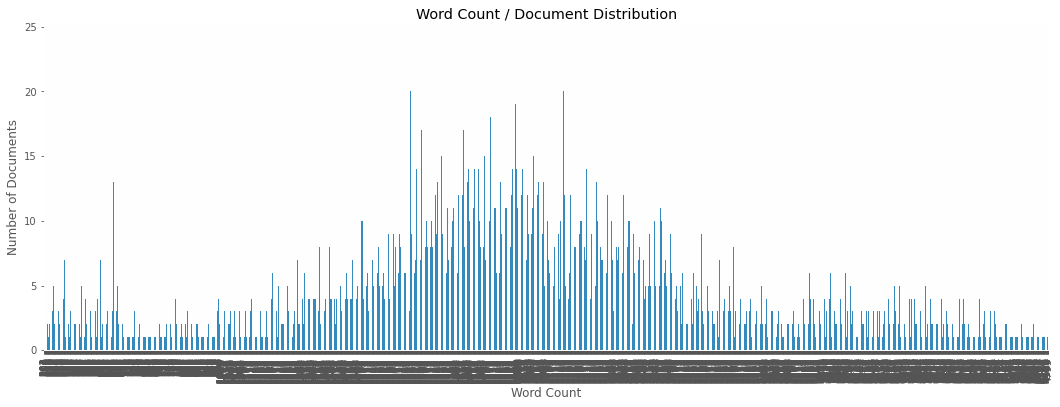

time: 57.5 s


In [556]:
with plt.style.context('ggplot'):
    ax = dt3c['wc'].value_counts().sort_index().plot(
        kind='bar', color='C1', title='Word Count / Document Distribution', figsize=(18, 6))
    ax.set_xlabel("Word Count")
    ax.set_ylabel("Number of Documents")

In [554]:
print(wc_count)

201      2
202      3
203      1
204      3
206      1
207      2
208      2
209      2
210      3
211      1
212      2
213      2
214      1
216      3
217      1
218      4
219      3
220      2
222      2
223      3
224      1
225      1
226      1
227      1
228      2
229      2
230      1
232      3
233      1
234      1
235      5
236      3
237      2
238      2
239      2
240      3
241      4
242      4
244      1
245      2
246      4
247      1
248      6
249      2
250      1
251      1
252      3
253      1
254      4
256      2
257      3
258      4
260      2
261      3
262      2
263      2
264      1
266      1
267      3
268      5
269      4
271      2
272      4
273      2
274      1
275      7
277      1
278      4
279      1
280      2
281      2
282      2
283      5
284      2
285      1
286      3
287      3
288      2
289      2
290      1
291      3
292      1
293      2
294      2
295      3
296      5
297      3
298      3
300      3
301      1
302      1

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



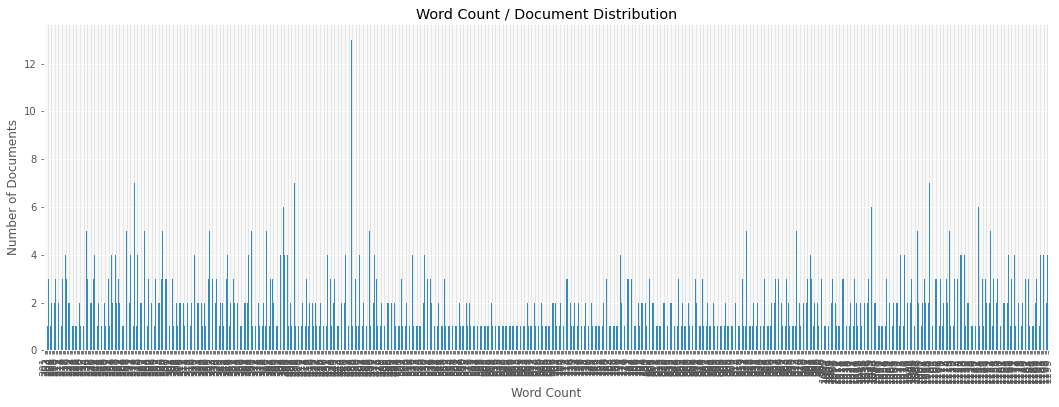

time: 14 s


In [552]:
with plt.style.context('ggplot'):
    ax = wc_count.plot(
        kind='bar', color='C1', title='Word Count / Document Distribution', figsize=(18, 6))
    ax.set_xlabel("Word Count")
    ax.set_ylabel("Number of Documents")

In [433]:
print(len(dt3c['wc'].values))
print(min(dt3c['wc'].values))
print(max(dt3c['wc'].values))

15194
3
1501
time: 5.12 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [454]:
print(len(papers_has_10_words['wc'].values))
print(min(papers_has_10_words['wc'].values))
print(max(papers_has_10_words['wc'].values))

13896
201
1199
time: 38.5 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [430]:
papers_has_10_words = dt3c[dt3c['wc']==3]
papers_has_10_words['file_path'].head(5)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



3323    /Users/farukcankaya/Google Drive/AllPapers/14_EAR/113_EAR.pdf
3416    /Users/farukcankaya/Google Drive/AllPapers/14_EAR/644_EAR.pdf
3562    /Users/farukcankaya/Google Drive/AllPapers/14_EAR/657_EAR.pdf
3605    /Users/farukcankaya/Google Drive/AllPapers/14_EAR/685_EAR.pdf
3639    /Users/farukcankaya/Google Drive/AllPapers/14_EAR/719_EAR.pdf
Name: file_path, dtype: object

time: 28.4 ms


In [455]:
dt3c = papers_has_10_words.copy()
print(dt3c.info())
dt3c.reset_index(drop=True, inplace=True)
print(dt3c.info())

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 13896 entries, 0 to 15193
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        13896 non-null  object
 1   Author           7074 non-null   object
 2   date             13683 non-null  object
 3   title            12343 non-null  object
 4   content_3        13896 non-null  object
 5   content_5        13896 non-null  object
 6   content_10       13896 non-null  object
 7   content_3_lang   13896 non-null  object
 8   content_5_lang   13896 non-null  object
 9   content_10_lang  13896 non-null  object
 10  wc               13896 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13896 entries, 0 to 13895
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        13896 non-null  object
 1   A

## 3. Remove non-relevant data

In [313]:
dt3c_copy2 = dt3c.copy()
non_matched_indexes = []
for i in range(0, len(dt3c['file_path'])):
  if not rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    non_matched_indexes.append(i)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1min 42s


In [314]:
print(len(non_matched_indexes))

4180
time: 481 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
print(non_matched_indexes)

[1, 3, 11, 13, 14, 17, 18, 19, 20, 25, 26, 30, 33, 37, 41, 42, 43, 45, 46, 47, 49, 50, 51, 52, 53, 57, 60, 61, 64, 70, 71, 72, 73, 74, 75, 81, 96, 99, 102, 103, 106, 110, 112, 116, 117, 119, 121, 122, 123, 124, 125, 126, 135, 137, 138, 142, 144, 146, 148, 149, 151, 156, 159, 161, 162, 163, 165, 166, 167, 169, 170, 174, 178, 180, 188, 191, 197, 203, 206, 211, 215, 216, 219, 220, 221, 224, 226, 228, 229, 230, 231, 232, 233, 235, 239, 241, 242, 246, 251, 252, 253, 254, 256, 259, 261, 262, 264, 265, 267, 271, 273, 274, 275, 276, 277, 279, 280, 281, 283, 284, 285, 287, 288, 289, 295, 298, 299, 300, 302, 304, 307, 310, 311, 312, 314, 315, 316, 317, 318, 321, 327, 328, 332, 333, 334, 336, 338, 340, 344, 346, 347, 353, 354, 356, 358, 362, 364, 365, 369, 372, 373, 381, 383, 384, 386, 389, 391, 393, 394, 396, 399, 401, 402, 404, 406, 407, 408, 410, 411, 413, 416, 419, 421, 422, 423, 424, 425, 427, 428, 432, 433, 437, 438, 442, 444, 449, 452, 454, 455, 457, 458, 460, 462, 463, 465, 468, 469, 472,

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c.iloc[non_matched_indexes]['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1             /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf
3             /Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf
11            /Users/farukcankaya/Google Drive/AllPapers/8_AH/703_AH.pdf
13            /Users/farukcankaya/Google Drive/AllPapers/8_AH/660_AH.pdf
14            /Users/farukcankaya/Google Drive/AllPapers/8_AH/131_AH.pdf
17             /Users/farukcankaya/Google Drive/AllPapers/8_AH/70_AH.pdf
18            /Users/farukcankaya/Google Drive/AllPapers/8_AH/119_AH.pdf
19            /Users/farukcankaya/Google Drive/AllPapers/8_AH/648_AH.pdf
20             /Users/farukcankaya/Google Drive/AllPapers/8_AH/58_AH.pdf
25            /Users/farukcankaya/Google Drive/AllPapers/8_AH/582_AH.pdf
26             /Users/farukcankaya/Google Drive/AllPapers/8_AH/25_AH.pdf
30             /Users/farukcankaya/Google Drive/AllPapers/8_AH/46_AH.pdf
33             /Users/farukcankaya/Google Drive/AllPapers/8_AH/37_AH.pdf
37            /Users/farukcankaya/Google Drive/AllP

time: 239 ms


In [ ]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15219 entries, 0 to 15218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15219 non-null  object
 1   Author           7808 non-null   object
 2   date             15006 non-null  object
 3   title            13571 non-null  object
 4   content_3        15219 non-null  object
 5   content_5        15219 non-null  object
 6   content_10       15219 non-null  object
 7   content_3_lang   15219 non-null  object
 8   content_5_lang   15219 non-null  object
 9   content_10_lang  15219 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
time: 117 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c = dt3c.drop(non_matched_indexes)

time: 19.9 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11014 entries, 0 to 15218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        11014 non-null  object
 1   Author           5799 non-null   object
 2   date             11002 non-null  object
 3   title            10051 non-null  object
 4   content_3        11014 non-null  object
 5   content_5        11014 non-null  object
 6   content_10       11014 non-null  object
 7   content_3_lang   11014 non-null  object
 8   content_5_lang   11014 non-null  object
 9   content_10_lang  11014 non-null  object
dtypes: object(10)
memory usage: 946.5+ KB
time: 17.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11014 entries, 0 to 11013
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        11014 non-null  object
 1   Author           5799 non-null   object
 2   date             11002 non-null  object
 3   title            10051 non-null  object
 4   content_3        11014 non-null  object
 5   content_5        11014 non-null  object
 6   content_10       11014 non-null  object
 7   content_3_lang   11014 non-null  object
 8   content_5_lang   11014 non-null  object
 9   content_10_lang  11014 non-null  object
dtypes: object(10)
memory usage: 860.6+ KB
time: 16.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c.to_pickle('en_cleaned_stop_words_lemmatized_3_5_10.pkl')

## 4. Visualize Data

In [209]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_list,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(dt3c['content_3']))

print(wordcloud)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1min 28s


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



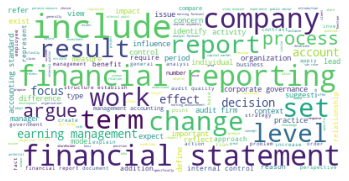

time: 725 ms


In [210]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [211]:
NUM_OF_TOPICS = 30
NUM_OF_WORDS_IN_EACH_TOPIC = 20

time: 424 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [212]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

time: 2.06 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Unigrams

In [213]:
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dt3c['content_3'], NUM_OF_WORDS_IN_EACH_TOPIC)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} unigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list_of_most_common_surnames', 'll', 'male', 'names', 'org', 'rep', 'shouldn', 've', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.



time: 18.8 s


## Bigrams

In [214]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(dt3c['content_3'], NUM_OF_WORDS_IN_EACH_TOPIC)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} bigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 52.3 s


In [215]:
"""
dt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title'])
dt3c['content_3'] = dt['en_clean_content_3_stop_words_lemma']

dt3c.info()

unknown_lang_indexes = dt.index[dt['en_clean_content_3_lang'].str.match('UNKNOWN')]
dt3c = dt3c.drop(unknown_lang_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()
"""

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



"\ndt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title'])\ndt3c['content_3'] = dt['en_clean_content_3_stop_words_lemma']\n\ndt3c.info()\n\nunknown_lang_indexes = dt.index[dt['en_clean_content_3_lang'].str.match('UNKNOWN')]\ndt3c = dt3c.drop(unknown_lang_indexes)\n\ndt3c.info()\ndt3c.reset_index(drop=True, inplace=True)\ndt3c.info()\n"

time: 8.92 ms


In [216]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15150 non-null  object
 1   Author           7758 non-null   object
 2   date             14937 non-null  object
 3   title            13503 non-null  object
 4   content_3        15150 non-null  object
 5   content_5        15150 non-null  object
 6   content_10       15150 non-null  object
 7   content_3_lang   15150 non-null  object
 8   content_5_lang   15150 non-null  object
 9   content_10_lang  15150 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
time: 3.79 s


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# 4. LDA Topic Modeling

In [217]:
import pyLDAvis
import pyLDAvis.sklearn

count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words=stop_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000)

data_vectorized = count_vectorizer.fit_transform(dt3c['content_3'])

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.



time: 3min 4s


## 4.1. Visualize topics
By default the topics are projected to the 2D plane using PCoA on a distance matrix created using the <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence">Jensen-Shannon divergence</a> on the topic-term distributions. You can pass in a different multidimensional scaling function via the mds parameter. In addition to <b>pcoa</b>, other provided options are <b>tsne</b> and <b>mmds</b> which operate on the same JS-divergence distance matrix. Both tsne and mmds require that you have sklearn installed. 


Dimension reduction via Jensen-Shannon Divergence &
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">TSNE - t-distributed Stochastic Neighbor Embedding</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS">MMDS - Metric Multidimensional Scaling</a> <a href="https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html">Check Example</a>
- <a href="">PCOA - Principal Coordinate Analysis(aka Classical Multidimensional Scaling)</a>

Answer: https://stackoverflow.com/questions/50923430/what-does-the-parameter-mds-mean-in-the-pyldavis-sklearn-prepare-function

We used tsne below. Check for others: https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
Also check to learn how LDAVis works: https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
And check the LDAVis from the original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
Why LDAVis presentation: https://speakerdeck.com/bmabey/visualizing-topic-models

In [218]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
4      119.070190   64.655502       1        1  8.438845
22      54.382130  109.799164       2        1  5.555556
19    -161.423965 -103.744957       3        1  5.280301
28    -135.370758   36.673065       4        1  5.275694
14     177.317215  -66.872452       5        1  5.258934
26     -16.436356  142.453796       6        1  5.163573
11      31.052383  204.777573       7        1  4.905958
8      -25.024384 -186.083466       8        1  4.802229
21     -68.157486   20.934038       9        1  4.062343
24      -3.751695    4.961509      10        1  4.029877
27    -114.470009 -179.605469      11        1  3.830224
3     -110.729126  -40.476776      12        1  3.785905
6       42.552418  -42.789406      13        1  3.521643
23     -10.661536   71.922211      14        1  3.204099
29     112.652969  -16.279951      15        1  3.091546
5     -195.499146  -25.853945      16        1  2.925375
7     -207.165924   66.070419      17        1  2.726258
18      10.217649 -110.752060      18        1  2.624199
13     -81.255081   96.477776      19        1  2.531720
25     -77.253441  192.755219      20        1  2.344584
2      182.353027  110.412880      21        1  2.287550
17      89.766510  -93.997673      22        1  2.254072
16     -36.483528  -52.542774      23        1  2.131179
15     -72.052170 -112.144821      24        1  1.992447
1      144.822769 -150.811508      25        1  1.945624
10    -148.475357  135.678162      26        1  1.692594
20     189.811615   17.382956      27        1  1.375285
0       56.555355   33.755768      28        1  1.219964
12      58.988537 -178.376541      29        1  1.112304
9      110.556717  164.236694      30        1  0.630118, topic_info=                      Term           Freq          Total Category  logprob  \
1894                  firm  132246.000000  132246.000000  Default  30.0000   
366                  audit   65173.000000   65173.000000  Default  29.0000   
1469               earning   60187.000000   60187.000000  Default  28.0000   
371                auditor   54264.000000   54264.000000  Default  27.0000   
4483                   tax   35468.000000   35468.000000  Default  26.0000   
1329            disclosure   36685.000000   36685.000000  Default  25.0000   
48              accounting   84795.000000   84795.000000  Default  24.0000   
2270               ination   69295.000000   69295.000000  Default  23.0000   
3255               perance   38040.000000   38040.000000  Default  22.0000   
3938                  risk   40662.000000   40662.000000  Default  21.0000   
212                analyst   24734.000000   24734.000000  Default  20.0000   
2740            management   47879.000000   47879.000000  Default  19.0000   
1884             financial   68888.000000   68888.000000  Default  18.0000   
1930              forecast   19239.000000   19239.000000  Default  17.0000   
2450              internal   21841.000000   21841.000000  Default  16.0000   
3855              research   63972.000000   63972.000000  Default  15.0000   
980                control   34097.000000   34097.000000  Default  14.0000   
2765                market   50611.000000   50611.000000  Default  13.0000   
1010             corporate   28668.000000   28668.000000  Default  12.0000   
3583                public   29165.000000   29165.000000  Default  11.0000   
4080               service   13320.000000   13320.000000  Default  10.0000   
3832                report   52086.000000   52086.000000  Default   9.0000   
4181                social   20337.000000   20337.000000  Default   8.0000   
3197                 paper   45653.000000   45653.000000  Default   7.0000   
1027                  cost   40793.000000   40793.000000  Default   6.0000   
2507              investor   30104.000000   30104.000000  Default   5.0000   
696                 client 

time: 17.6 s


In [219]:
print(count_vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=3,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'(former', '.002%.', '1990', '>', 'a',
                                      "a's", 'aaron', 'abbey', 'abbie',
                                      'abbott', 'abby', 'abdul', 'abdullah',
                                      'abe', 'abel', 'abell', 'abercrombie',
                                      'abernathy', 'abeyta', 'abigail', 'able',
                                      'ables', 'abner', 'abney', 'about',
                                      'above', 'abraham', 'abram', 'abrams',
                                      'abramson', ...}),
                strip_accents=None, token_pattern='[a-zA-Z0-9]{3,}',
                tokenizer=None, vocabulary=None)
time: 58.5 ms

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [220]:
print(data_vectorized.toarray())

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
time: 355 ms


In [221]:
topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

time: 763 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [222]:
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords['topic_theme'] = topic_names
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic_theme,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Word 0,paper,strategy,risk,earning,accounting,investment,ination,management,decision,service,compensation,research,author,environmental,audit,fraud,analyst,accounting,perance,cost,accounting,financial,firm,corporate,model,tax,market,work,standard,public
Word 1,issue,strategic,control,accrual,practice,capital,disclosure,internal,manager,committee,option,study,article,social,auditor,restatement,forecast,asset,measure,model,student,company,industry,governance,accounting,income,return,accountant,accountability,government
Word 2,review,customer,internal,management,account,debt,report,control,effect,expertise,incentive,paper,table,corporate,client,financial,earning,cost,study,process,research,reporting,cost,shareholder,asset,rate,investor,account,financial,sector
Word 3,conference,business,financial,firm,paper,financial,investor,organization,individual,expert,executive,literature,text,report,quality,security,ination,financial,target,ination,education,report,increase,director,estimate,dividend,trading,accounting,regulation,private
Word 4,editor,relationship,assessment,manager,research,credit,disclose,external,task,care,contract,method,chapter,stakeholder,auditing,litigation,accuracy,liability,evaluation,product,account,accounting,effect,ownership,conservatism,taxis,announcement,business,accounting,policy
Word 5,process,control,section,report,theory,risk,financial,organizational,result,health,pay,analysis,include,sustainability,big,company,investor,pension,acquisition,technology,business,standard,result,firm,flow,taxation,trade,history,professional,political
Word 6,letter,transfer,material,discretionary,process,rating,provide,budget,behavior,hospital,employee,researcher,publication,company,study,report,recommendation,balance,manager,base,academic,quality,level,company,valuation,avoidance,equity,people,public,local
Word 7,author,trust,misstatement,evidence,social,market,untary,function,theory,member,base,datum,style,csr,independence,event,error,debt,result,resource,university,adoption,study,control,loss,effect,share,world,issue,economy
Word 8,offer,network,report,increase,study,bank,user,manager,agent,financial,ceo,section,figure,organisation,partner,concern,research,expense,effect,production,journal,statement,examine,agency,income,corporate,risk,life,profession,economic
Word 9,initial,management,weakness,result,change,crisis,content,role,judgment,industry,bonus,finding,submit,legitimacy,result,reputation,guidance,statement,job,business,publish,list,evidence,structure,future,capital,ination,economic,regulatory,paper


time: 134 ms


# 4.2. Extract Topics

In [223]:
# Create Document - Topic Matrix
lda_output2 = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(dt3c))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(dt3c, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['file_path', 'dominant_topic']]

def label_theme(row):
    return "Topic " + str(row)
        
df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)
df_topic_theme.head(15)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-223-9689e41583c7>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,file_path,dominant_topic,dominant_topic_theme
0,/Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf,19,Topic 19
1,/Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf,27,Topic 27
2,/Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf,15,Topic 15
3,/Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf,28,Topic 28
4,/Users/farukcankaya/Google Drive/AllPapers/8_AH/123_AH.pdf,23,Topic 23
5,/Users/farukcankaya/Google Drive/AllPapers/8_AH/672_AH.pdf,16,Topic 16
6,/Users/farukcankaya/Google Drive/AllPapers/8_AH/394_AH.pdf,14,Topic 14
7,/Users/farukcankaya/Google Drive/AllPapers/8_AH/398_AH.pdf,6,Topic 6
8,/Users/farukcankaya/Google Drive/AllPapers/8_AH/298_AH.pdf,19,Topic 19
9,/Users/farukcankaya/Google Drive/AllPapers/8_AH/603_AH.pdf,14,Topic 14


time: 9.89 s


## 4.3. Make Prediction

In [224]:
print(lda_output.shape)
topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))
print(topic_sum.shape)

(15150, 30)
(15150, 1)
time: 1.62 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [225]:
column_names = ['file_path', 'content_10'] + topic_names + ['sum']

# Turn our docs_nmf array into a data frame
doc_topic_df = pd.DataFrame(data = lda_output)

# Merge all of our article metadata and name columns
doc_topic_df = pd.concat([dt3c[['file_path', 'content_3']], 
                          doc_topic_df, topic_sum], axis = 1)


time: 106 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [226]:
doc_topic_df.columns = column_names

time: 600 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [227]:
doc_topic_df.head(1)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

time: 33.1 ms


In [228]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   15150 non-null  object 
 1   content_10  15150 non-null  object 
 2   Topic 1     15150 non-null  float64
 3   Topic 2     15150 non-null  float64
 4   Topic 3     15150 non-null  float64
 5   Topic 4     15150 non-null  float64
 6   Topic 5     15150 non-null  float64
 7   Topic 6     15150 non-null  float64
 8   Topic 7     15150 non-null  float64
 9   Topic 8     15150 non-null  float64
 10  Topic 9     15150 non-null  float64
 11  Topic 10    15150 non-null  float64
 12  Topic 11    15150 non-null  float64
 13  Topic 12    15150 non-null  float64
 14  Topic 13    15150 non-null  float64
 15  Topic 14    15150 non-null  float64
 16  Topic 15    15150 non-null  float64
 17  Topic 16    15150 non-null  float64
 18  Topic 17    15150 non-null  float64
 19  Topic 18    15150 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [229]:
# Remove articles with topic sum = 0, then drop sum column
doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
doc_topic_df.drop(columns = 'sum', inplace = True)

# Reset index then save
doc_topic_df.reset_index(drop = True, inplace = True)
#doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 7.8 ms


In [230]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   15150 non-null  object 
 1   content_10  15150 non-null  object 
 2   Topic 1     15150 non-null  float64
 3   Topic 2     15150 non-null  float64
 4   Topic 3     15150 non-null  float64
 5   Topic 4     15150 non-null  float64
 6   Topic 5     15150 non-null  float64
 7   Topic 6     15150 non-null  float64
 8   Topic 7     15150 non-null  float64
 9   Topic 8     15150 non-null  float64
 10  Topic 9     15150 non-null  float64
 11  Topic 10    15150 non-null  float64
 12  Topic 11    15150 non-null  float64
 13  Topic 12    15150 non-null  float64
 14  Topic 13    15150 non-null  float64
 15  Topic 14    15150 non-null  float64
 16  Topic 15    15150 non-null  float64
 17  Topic 16    15150 non-null  float64
 18  Topic 17    15150 non-null  float64
 19  Topic 18    15150 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [231]:
doc_topic_df[['file_path']+topic_names].head(3).T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,0,1,2
file_path,/Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf,/Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf,/Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf
Topic 1,0.0121885,0.0889905,5.50964e-05
Topic 2,5.69801e-05,8.23045e-05,0.00658819
Topic 3,5.69801e-05,8.23045e-05,5.50964e-05
Topic 4,5.69801e-05,8.23045e-05,0.0436513
Topic 5,0.136792,8.23045e-05,0.0252145
Topic 6,5.69801e-05,0.00977874,5.50964e-05
Topic 7,5.69801e-05,8.23045e-05,0.0229321
Topic 8,0.0231703,0.0469541,5.50964e-05
Topic 9,0.124728,8.23045e-05,5.50964e-05


time: 12.6 ms


In [232]:
topic_array = np.array(doc_topic_df[topic_names])

print(topic_array.shape)

print(topic_array[0])

(15150, 30)
[1.21885055e-02 5.69800570e-05 5.69800570e-05 5.69800570e-05
 1.36792296e-01 5.69800570e-05 5.69800570e-05 2.31703016e-02
 1.24727758e-01 5.69800570e-05 5.69800570e-05 6.16088582e-02
 1.53497924e-02 1.83273490e-01 5.69800570e-05 5.69800570e-05
 5.69800570e-05 5.69800570e-05 5.69800570e-05 2.16697477e-01
 5.69800570e-05 1.32345067e-01 7.76968664e-02 5.69800570e-05
 5.69800570e-05 5.69800570e-05 1.50669666e-02 5.69800570e-05
 5.69800570e-05 5.69800570e-05]
time: 4.93 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## 4.4. Prepare pre-trained model
### 4.4.1. Save the model
Save the model to use as pre-trained model on the https://simple-recommender.herokuapp.com/ website.

In [233]:
import pickle

topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

topic_array = np.array(doc_topic_df[topic_names])
norms = np.linalg.norm(topic_array, axis = 1)

pickle.dump( norms, open( "model__norms.pkl", "wb" ) )
pickle.dump( topic_array, open( "model__topic_array.pkl", "wb" ) )
df_topic_keywords.to_pickle('model__df_topic_keywords.pkl')
pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )
pickle.dump( lda_model, open( "model__lda_model.pkl", "wb" ) )
pickle.dump( count_vectorizer, open( "model__count_vectorizer.pkl", "wb" ) )
pickle.dump( stop_list, open( "model__stop_list.pkl", "wb" ) )



/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 406 ms


### 4.4.2. Add Title, Author, metadata to core model
Use useful data from RELAVENT_DATA.xlsx

In [234]:
x = dt3c.copy()
# Paper Name, Author Name(s), Year and Journal
print(x['date'].isna().sum())
x['date'] = x['date'].fillna(0)
print(x['date'].isna().sum())

doc_topic_df['year'] = x['date']

213
0
time: 64.3 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [235]:
def combine_authors(author_list):
  if isinstance(author_list, list):
    return ', '.join(author_list)

  return author_list

x['Author'] = x['Author'].fillna('-')
x['authors'] = x['Author'].apply(combine_authors)

doc_topic_df['authors'] = x['authors']

time: 9.82 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [236]:
print(x['title'].isna().sum())
x['title'] = x['title'].fillna('-')
print(x['title'].isna().sum())

doc_topic_df['title'] = x['title']

1647
0
time: 5.39 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [237]:
def journal_name(text):
  text = get_file_name(text)
  t = re.findall('([0-9]+)_([a-zA-Z]+)', text, re.IGNORECASE)
  return [i[1] for i in t][0]

doc_topic_df['journal'] = x['file_path'].apply(journal_name)
doc_topic_df['journal'].head(5)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0    AH
1    AH
2    AH
3    AH
4    AH
Name: journal, dtype: object

time: 62 ms


In [238]:
rt = pd.read_excel('/Users/farukcankaya/FC/GoogleDrive/DATA_RELEVANT.xlsx')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.it

time: 19 s


In [239]:
rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt['file_path'][0]))][0]]['Title']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'The effect of system characteristics, stage of adoption, and experience on institutional explanations for ERP systems choice'

time: 12.8 ms


In [240]:
titles = []
for i in range(0, len(dt3c['file_path'])):
  if rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    titles.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Title'])
  else:
    titles.append(dt3c['title'][i])
      

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 45s


In [241]:
pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 431 ms


In [242]:
# LOAD pre-trained model if you just want to make prediction here.
"""
norms     = pickle.load( open( "model__norms.pkl", "rb" ) )
topic_array     = pickle.load( open( "model__topic_array.pkl", "rb" ) )
df_topic_keywords = pickle.load( open( "model__df_topic_keywords.pkl", "rb" ) )
doc_topic_df = pickle.load( open( "model__doc_topic_df.pkl", "rb" ) )
lda_model = pickle.load( open( "model__lda_model.pkl", "rb" ) )
count_vectorizer   = pickle.load( open( "model__count_vectorizer.pkl", "rb" ) )
stop_list     = pickle.load( open( "model__stop_list.pkl", "rb" ) )
"""

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'\nnorms     = pickle.load( open( "model__norms.pkl", "rb" ) )\ntopic_array     = pickle.load( open( "model__topic_array.pkl", "rb" ) )\ndf_topic_keywords = pickle.load( open( "model__df_topic_keywords.pkl", "rb" ) )\ndoc_topic_df = pickle.load( open( "model__doc_topic_df.pkl", "rb" ) )\nlda_model = pickle.load( open( "model__lda_model.pkl", "rb" ) )\ncount_vectorizer   = pickle.load( open( "model__count_vectorizer.pkl", "rb" ) )\nstop_list     = pickle.load( open( "model__stop_list.pkl", "rb" ) )\n'

time: 2.37 ms


## 4.5. Measure similarity

In [243]:
def compute_dists(top_vec, topic_array):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array)
    return doc_topic_df.loc[np.argmax(co_dists)]

time: 1.34 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [244]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words

    # Clean
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    #
    for i in range(len(text)):
      text[i] = replace_text(text[i])
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    # Remove stopwords
    for i in range(len(text)):
      text[i] = remove_stopwords(text[i])
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize is skipped !!!
    # mytext_3_1 = []
    # for sent in mytext_2:
    #   mytext_3_1.append(" ".join(sent))
    # Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    #print(mytext_3[0][0:100]+" ...")
    
    # stemming is skipped !!!
    #mytext_3_1 = []
    #for t in mytext_3:
    #  mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = count_vectorizer.transform(mytext_3)
    
    #print('Count vectorizer of transformed text: {}'.format(mytext_4.shape))
    #print('Vectorized data {}'.format(data_vectorized.shape))
    #print('First 100 Feature names:')
    #print(count_vectorizer.get_feature_names()[:100])
    #print('')
    

    # LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

time: 835 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## 4.6 Make single prediction

In [245]:
# Predict the topic
TAR_6 = ["We examine how subjective performance evaluations are influenced by the level and controllability of an accompanying measure of a separate performance dimension. In our experiment, supervisors evaluate the office administration perfor- mance of a hypothetical subordinate. We find that supervisors’ subjective evaluations are directionally influenced by an accompanying objective measure of sales perfor- mance, even after excluding participants who perceive informativeness across measures. Consistent with concerns for fairness and motivation, we also find an asymmetric uncontrollability effect—supervisors’ evaluations are higher when an uncontrollable factor decreases the subordinate’s sales (i.e., they compensate for bad luck), but are not lower when the uncontrollable factor increases the subordinate’s sales (i.e., they do not punish for good luck). This evidence suggests that supervisors use discretion provided to evaluate performance on one task to adjust for perceived deficiencies in the evaluation of performance on other tasks. Our study integrates theories of cognitive bias and motivation, highlighting the need to consider the potentially interactive effects of different performance measures in multi-task settings I. INTRODUCTION Organizational incentive systems often allow managerial discretion in the evaluation of employee performance (Murphy and Oyer 2003). Subjective performance evaluation allows managers to use noncontractible information to assess actions and efforts that objective measures (such as those produced by the accounting system) are not able to capture, creating a more complete depiction of employee performance (Bol 2008).1 Subjectivity can therefore be useful in reducing risk to employees and improving the incentive alignment of the firm’s performance measurement system (Baker et al. 1994; Bushman et al. 1996; Hayes and Schaefer 2000).2 Many performance measurement systems include both objective measures and subjective evaluations (Prendergast 1999; Gibbs et al. 2004). While designed to capture separate dimensions of employee performance, these different measurement types can influence each other. For example, theories from psychology and organizational behavior suggest that subjective judgments can be unduly influenced by an individual’s knowledge of other, unrelated information (Nisbett et al. 1981; Bond et al. 2007). Such an influence could limit the complementary role of subjective evaluation in improving the overall informativeness of the measures used to evaluate performance. We examine how supervisors’ subjective performance evaluations are affected by the level and controllability of an objective measure of a separate aspect of performance. We analyze a two-dimensional employment setting in which an employee’s performance on one dimension (i.e., task) is measured objectively, while performance on the other dimension is evaluated subjectively by the supervisor. In many such settings, the objective performance measure is known by the supervisor before s/he subjectively evaluates the employee’s performance on the other dimension (Huber et al. 1987; Bommer et al. 1995). Our first research question examines whether the level of the objective measure has a directional impact on the supervisor’s subjective evaluation. Specifically, we examine whether, consistent with cognitive distortion, supervisors bias their subjective evaluations of performance on one dimension to be consistent with an objective measure of performance on a separate and unrelated dimension.3 Our second research question considers how such a spillover effect differs when the controllability of the objective performance measure is relatively low. Uncontrollability introduces noise and error into the performance measurement system (Feltham and Xie 1994), and has been shown to affect attribution judgments (Tan and Lipe 1997). Employees are likely to perceive uncontrollable performance measures to be unfair when the uncontrollability reduces measured performance. Perceptions of unfairness in compensation lead to reduced job satisfaction and motivation (Cohen-Charash and Spector 2001; Colquitt et al. 2001). We examine whether this expectation is reflected in supervisors’ use of their discretion, even when that discretion is provided for the evaluation of a separate task. Specifically, we examine whether supervisors use the discretion in their subjective evaluations to adjust for (or offset) the effects of an uncontrollable objective measure. Consistent with concerns for fairness and employee motivation, we predict that supervisors will make such an adjustment when the uncontrollable factor reduces measured performance (i.e., the employee suffers from bad luck) but not when it increases measured performance (i.e., the employee benefits from good luck). In our experiment, experienced supervisors employed by a large state university participate as evaluators in a hypothetical case setting. Participants assume the role of a regional director with supervisory authority over district managers who have both sales- and office administration-related duties. Objective individual sales information is given, after which participants are charged with subjectively evaluating the office administration performance of one district manager based on personal notes and staff interview responses, which are held constant in all conditions. The experiment employs a 2 3 2 þ 1 between-subjects design. In four treatment conditions, we manipulate the level of the manager’s individual sales at two levels by varying the objective sales score (high and low), and we manipulate the controllability of the individual sales measure at two levels by varying whether significant but uncontrollable events impacted the manager’s sales during the period. A fifth (control) condition includes only the information about the manager’s office administration performance. We find that supervisors’ subjective evaluations of the manager’s office administration performance are significantly higher (lower) when the objective level of the manager’s individual sales measure is relatively high (low). By excluding those participants who perceived the individual sales measure to be informative about the manager’s office administration performance in our primary analysis, we provide evidence of cognitive distortion of performance information as a result of exposure to the objective measure. We also find that the effect of the objective measure depends on its controllability. Specifically, participants use their subjective evaluations to adjust for the impact of uncontrollable events on the sales measure. Consistent with theory, this effect is asymmetric—participants’ evaluations are higher (relative to the high controllability condition) when the uncontrollable factor leads to an unfavorable outcome, but are no lower when the uncontrollable factor leads to a favorable outcome. Thus, we find that participants use their discretion to compensate for bad luck, but not to punish for good luck. This study contributes to the accounting and management literatures on performance evaluation. Prior research on bias in performance evaluation has found that supervisors’ subjective evaluations of current performance may be directionally influenced by prior performance information (Murphy et al. 1985; Huber et al. 1987; Kravitz and Balzer 1992) or information from different sources (Blakely 1993; Murphy and Cleveland 1995; Bono and Colbert 2005). Our study contributes to this line of research by showing that cognitive distortion can cause spillover from the objective evaluation of one dimension of performance to the subjective evaluation of performance on a separate and unrelated dimension. Prior research has also found evidence that controllability concerns can affect evaluators’ judgments in single-dimension performance-evaluation settings. For example, Tan and Lipe (1997) find that controllability moderates outcome effects in evaluators’ judgments (also see Brown and Solomon 1987). Our study reveals a very different controllability effect. Specifically, our results suggest that supervisors can use discretion that is provided for the evaluation of performance on a particular dimension to ‘‘correct’’ perceived deficiencies in other areas of the evaluation system. While the use of ‘‘borrowed’’ discretion can yield motivational benefits for employees, the intended benefits of that discretion (i.e., accurate reflection of performance on a specific dimension) can be reduced. Overall, our evidence indicates that the known level of an objective performance measure compromises the effectiveness of subjective performance evaluation for completing the picture of employee performance. Thus, our results have implications for the weight, timing, and nature of subjectivity in compensation contracting, suggesting that consideration of different measurement types in isolation can lead to incomplete conclusions about the optimal design of performance measurement systems. An asymmetric pattern of compensation payouts, in which managers are sheltered from downside risk but are allowed the advantages of upside risk, has been demonstrated in accounting"]
AOS_3 = ["This paper is focused on the way in which inter®rm relations can be drawn up and controlled. Drawing on con- tracting theories a model is built of the management control structure of inter®rm relationships. The model consists of three control patterns and of contingency factors that in ̄uence the choices between the patterns. Particular attention is paid to the role of trust. In building our model we take the perspective of the outsourcer. We try to re®ne our model by conducting case research in the ®eld of industrial renovation and industrial maintenance. In this ®eld we observed changes in the way outsourcing relationships are controlled. Case research can be very helpful for gaining insights into factors that in ̄uence the establishment of control structures of inter®rm relationships. By comparing the results of our case research we found institutional, strategic, cultural and historical factors to be of great importance for these control structures. 5 1999 Elsevier Science Ltd. All rights reserved. The boundaries of ®rms are continuously sub- ject to changes. Firms add new activities, hive o􏰁 existing activities and set up new forms of coop- eration with other ®rms. The concentration on core activities is a tendency that already started several years ago. Non-core activities are hived o􏰁, so that the ®rm can concentrate on the activ- ities which it can perform well and which can thus produce the highest added value. Insight into which activities belong to the non-core activities is subject to changes too. We observe that conglom- erates with a great variety of products hive o complete product lines, but we also ®nd that ®rms, although they do not change their product mix, leave the production of components to other ®rms. We can also observe that ®rms outsource the provision of supporting services even more. Even services which are essential for the continuity of the ®rm, such as administration, information technology and maintenance. When the out- sourcing concerns essential components and ser- vices we observe the setting up of close forms of cooperation between ®rms. Hiving o􏰁 essential components and services requires a speci®c embeddedness of the outsourcing relation in order to guarantee its continuity and to retain the eco- nomic advantages of outsourcing in the long run. This makes demands on the macro as well as micro level. On the macro level these develop- ments must be supported by legal and institutional frameworks (such as contract law and the attitude of branch organisations and the trade unions). On the micro level they make demands on the orga- nisation of the ®rm's own activities, the coordina- tion with the suppliers and the employees' willingness to work closely together with people from outside their own ®rm. The structuring and control of inter®rm relations require the establish- ment of suitable management control systems and processes. This study is in particular aimed at the demands outsourcing relations make on the micro level. The question is: how can ®rms which enter into strategic alliances with other ®rms structure the management control of such inter®rm relationships? Management control and management accounting research usually concentrates on rela- tions within organisations with varying degrees of decentralisation of decision making. Robert Anthony's (1965, 1988) well-known framework in which the decomposition of the organisation into responsibility centers is paramount, is the implicit or explicit point of departure for a lot of formal behavioural and contingency research in manage- ment control. In numerous organisations a hor- izontalisation of management control relations can be observed. These control relations are not hierarchically based but are relations between equal internal parties. Customer-supplier relation systems are being set up with forms of internal contracting (service level agreements), e.g. with respect to facility services (Van der Meer-Kooistra, 1994; Vosselman, 1996). There used to be captive buyers and sellers, but now it is no longer excep- tional for departments to be allowed to deliver or to buy on external markets within rather  ̄exible limits. Otley (1994) too observes such a horizontalisation and proposes a broader management control fra- mework. Research into horizontal management control relations should not remain restricted to intra®rm relations, but be extended to inter®rm relations. Recently Hopwood urged ``(the) exam- ination of some of the accounting and informational consequences of more explicit concerns with the management of the supply chain and a more con- scious questioning of what activities reside within and without the enterprise'' (Hopwood, 1996, p. 590). In the relevant literature little attention is given to management control issues with regard to forms of cooperation between independent com- panies (inter®rm relations). It is in particular the strategic cost management literature (Cooper, 1995; Shank & Govindarajan, 1993) which draws attention to the importance of looking beyond the boundaries of the ®rm. These publications emphasise the value chain approach, which not only focuses on the relations between the various subsequent activities within the ®rm but also on the ®rm's relations with the suppliers of raw materials, components etc. and the buyers. Berry (1995) also focuses on extra-organisational control problems, in particular control in network orga- nisations. According to Gietzmann (1996) the role of the management accountant is changing due to control beyond the boundaries of the concern. When deciding on what should or should not be contracted out this role is much more complex than just calculating the production costs and comparing them with the market price. Make or buy decisions are becoming more and more of a strategic nature (see e.g. Tayles & Drury, 1997). ``The management accountant should play a cri- tical support role in the strategy debate concerning which elements (subcomponents) of product development can be outsourced, which should be developed in house and which do not warrant development since o􏰁 the shelf subcomponents su􏰂ce'' (Gietzmann, p. 624). Therefore the man- agement accountant needs not only information about the production costs and market prices but he also needs information about the costs and bene®ts of the speci®c forms of governance connected with these choices. Nowadays many make or buy decisions have evolved into what could be called `extended make or buy' decisions. An extended make or buy deci- sion can be divided into three separate, but inter- related elements. Firstly, the decision to purchase goods or services on a structural basis from third parties or to produce the goods or services in- house. Secondly, in the case of purchasing from third parties, the decision regarding the party or parties contracted. The nature of the party or parties in ̄uences the chance, and extent, of relational risks. Thirdly, decisions regarding the design of the internal management control system or the design of the outsourcing relationship."]
topic, prob_scores = predict_topic(text = TAR_6)
print('topic')
print(topic)
print('')
print('prob_scores')
print(prob_scores[0])
print("shape of prob_scores: {}".format(prob_scores[0].shape))
print('')


print("Try to make recommendation. Inputs:")
print("- prob_scores")
print("- topic_array: {} prob. distribution of topics for each document that is calculated by LDA".format(topic_array.shape))
print("- doc_topic_df: {} that is actually output of the LDA but combined with file_path, etc.".format(doc_topic_df.shape))
print('')

produce_rec(prob_scores.flatten(), topic_array, doc_topic_df)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic
['perance', 'measure', 'study', 'target', 'evaluation', 'acquisition', 'manager', 'result', 'effect', 'job', 'measurement', 'employee', 'base', 'research', 'level', 'merger', 'financial', 'suggest', 'turnover', 'satisfaction']

prob_scores
[6.12745098e-05 6.12745098e-05 2.44109240e-02 6.12745098e-05
 6.12745098e-05 6.12745098e-05 2.29334691e-02 1.29117624e-02
 2.11429683e-01 6.12745098e-05 2.85194797e-02 6.12745098e-05
 6.12745098e-05 6.12745098e-05 6.12745098e-05 6.12745098e-05
 6.12745098e-05 6.12745098e-05 6.63803757e-01 6.12745098e-05
 6.12745098e-05 6.12745098e-05 6.12745098e-05 4.03784625e-03
 6.12745098e-05 4.54390695e-03 6.12745098e-05 6.12745098e-05
 6.12745098e-05 2.61224071e-02]
shape of prob_scores: (30,)

Try to make recommendation. Inputs:
- prob_scores
- topic_array: (15150, 30) prob. distribution of topics for each document that is calculated by LDA
- doc_topic_df: (15150, 36) that is actually output of the LDA but combined with file_path, etc.



file_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

time: 344 ms


# 5. Calculate Accuracy
## 5.1. Calculate Top-5 Accuracy

In [246]:
from sklearn.metrics.pairwise import cosine_similarity

def produce_rec_top_n(top_vec, topic_array, doc_topic_df, n=5):
    co_dists = compute_dists(top_vec, topic_array)
    index_top_n = np.argpartition(co_dists, -n)[-n:]
    index_top_n = index_top_n[np.argsort(-co_dists[index_top_n])]
    return doc_topic_df.loc[index_top_n]
  
topic, prob_scores = predict_topic(text = TAR_6)

topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df)

rec_top_1 = recs[topic_columns].head(1).values

print('rec_top_1:')
print(rec_top_1)
print('prob_scores:')
print(prob_scores.flatten())
print('cosine_similarity:')
print(cosine_similarity(rec_top_1,prob_scores))

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



rec_top_1:
[[1.16066422e-02 5.46448087e-05 1.84356760e-02 5.46448087e-05
  5.46448087e-05 5.46448087e-05 1.38085370e-02 1.20916792e-02
  2.03767441e-01 5.46448087e-05 2.26327032e-02 5.46448087e-05
  5.46448087e-05 5.46448087e-05 5.46448087e-05 5.46448087e-05
  5.46448087e-05 5.46448087e-05 6.84043236e-01 5.46448087e-05
  5.46448087e-05 5.46448087e-05 5.46448087e-05 3.84890506e-03
  5.46448087e-05 3.95043861e-03 5.46448087e-05 5.46448087e-05
  5.46448087e-05 2.47218451e-02]]
prob_scores:
[6.12745098e-05 6.12745098e-05 2.44109240e-02 6.12745098e-05
 6.12745098e-05 6.12745098e-05 2.29334691e-02 1.29117624e-02
 2.11429683e-01 6.12745098e-05 2.85194797e-02 6.12745098e-05
 6.12745098e-05 6.12745098e-05 6.12745098e-05 6.12745098e-05
 6.12745098e-05 6.12745098e-05 6.63803757e-01 6.12745098e-05
 6.12745098e-05 6.12745098e-05 6.12745098e-05 4.03784625e-03
 6.12745098e-05 4.54390695e-03 6.12745098e-05 6.12745098e-05
 6.12745098e-05 2.61224071e-02]
cosine_similarity:
[[0.99951163]]
time: 293 ms


In [247]:
recs['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



7629        /Users/farukcankaya/Google Drive/AllPapers/1_TAR/6_TAR.pdf
2495      /Users/farukcankaya/Google Drive/AllPapers/3_JAR/215_JAR.pdf
979       /Users/farukcankaya/Google Drive/AllPapers/11_BAR/58_BAR.pdf
11132     /Users/farukcankaya/Google Drive/AllPapers/4_AOS/891_AOS.pdf
4077     /Users/farukcankaya/Google Drive/AllPapers/16_ABR/191_ABR.pdf
Name: file_path, dtype: object

time: 3.88 ms


## 5.2. Calculate Top 1,5,20,100 Accuracy

In [248]:
def accuracy_n(file_path, data, top_n=[1]):
  topic, prob_scores = predict_topic([data])

  topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
  recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df, max(top_n))

  existence = []
  
  for n in top_n:    
    if recs['file_path'].head(n).str.contains(get_file_name(file_path)).any():
      existence.append(1)
    else:
      existence.append(0)

  return pd.Series(existence)

time: 722 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [249]:
#dt3c['file_path'].apply().head(1)
#get_file_name('/Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf')
#dt3c['file_path'].parallel_apply(get_file_name).str.match('711_AH').head(1)

time: 357 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [250]:
#papers_has_10_words.index
xx = dt.copy().drop(unknown_lang_indexes)
print(xx.info())
xx.reset_index(drop=True, inplace=True)
print(xx.info())


non_normalized_indexes = []
yy = dt3c['file_path'].parallel_apply(get_file_name)
for i in range(0, len(xx['file_path'])):
  if not yy.str.match(get_file_name(xx['file_path'][i])).any():
    non_normalized_indexes.append(i)

print(x.info())
xx = xx.drop(non_normalized_indexes)
xx.reset_index(drop=True, inplace=True)
xx.info()



/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 15150 entries, 0 to 15750
Columns: 3435 entries, file_path to en_cleaned_accounting_replaced_stop_words_lemmatized_page_330
dtypes: float64(330), int64(337), object(2768)
memory usage: 397.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Columns: 3435 entries, file_path to en_cleaned_accounting_replaced_stop_words_lemmatized_page_330
dtypes: float64(330), int64(337), object(2768)
memory usage: 397.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15150 non-null  object
 1   Author           15150 non-null  object
 2   date             15150 non-null  object
 3   title            15150 non-null  object
 4   content_3        15150 non-null  object
 5   content_5        15150 non-null  object
 6   content_10       15150 non

In [251]:
## PARALLEL TEST
#xx = dt.copy().drop(unknown_lang_indexes)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], top_n), axis=1)
xx.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Columns: 3435 entries, file_path to en_cleaned_accounting_replaced_stop_words_lemmatized_page_330
dtypes: float64(330), int64(337), object(2768)
memory usage: 397.0+ MB
time: 20min 51s


In [252]:
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

Top-1 Score:0.40983498349834985
Top-5 Score:0.6319471947194719
Top-10 Score:0.712013201320132
Top-20 Score:0.7831023102310231
Top-50 Score:0.8685148514851485
Top-100 Score:0.9143234323432343
time: 6.56 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [208]:
# wrong replacement of words
Top-1 Score:0.20019788918205805
Top-5 Score:0.3779683377308707
Top-10 Score:0.46550131926121374
Top-20 Score:0.5584432717678101
Top-50 Score:0.6796174142480211
Top-100 Score:0.7680079155672823

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



SyntaxError: invalid syntax (<ipython-input-208-7d95e4c0936e>, line 2)

time: 42.6 ms


In [ ]:
# correct one without fixing prediction
Top-1 Score:0.18092409240924093
Top-5 Score:0.3576237623762376
Top-10 Score:0.44924092409240923
Top-20 Score:0.5405940594059406
Top-50 Score:0.6646864686468646
Top-100 Score:0.759075907590759